In [1]:
from datetime import date

print("Last run date:", date.today())

Last run date: 2023-03-08


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats
import os
import matplotlib
import math
import seaborn as sns

import lib.minibulk_funcs as mb
import lib.figs_funcs as figfunc
import lib.matx_funcs as matxfunc
import lib.fun_plotting as fun_plotting
import lib.funcs_ko as funcs_ko
import lib.NetAnalysis as na

%load_ext autoreload
%autoreload 2

In [3]:
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)

In [4]:
import os
current_path = os.getcwd()
current_path

'/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/GRN_Inference_CODE'

In [5]:
path = "/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/" # for Mac
path_data = path+"DATA/"

In [6]:
imp_genes = np.loadtxt(path_data+"general_info/imp_genes.csv", dtype="str")
imp_genes

array(['Klf4', 'Klf2', 'Esrrb', 'Tfcp2l1', 'Tbx3', 'Stat3', 'Tcf7l1',
       'Nanog', 'Sall4', 'Pou5f1', 'Sox2', 'Dnmt3a', 'Dnmt3b', 'Utf1',
       'Otx2', 'Etv5', 'Etv4', 'Nr0b1', 'Zic3', 'Lef1', 'Tcf15', 'Gbx2',
       'Pou3f1', 'Rbpj'], dtype='<U7')

In [7]:
data_type = "raw" # Or  "PsiNorm"
important_genes = True

if important_genes == True:
    text = "imp_genes_"+data_type
else:
    text = data_type
        
print(text)

imp_genes_raw


In [8]:
# GENE CLASSIFICATION
naive = ["Klf4", "Klf2", "Esrrb", "Tfcp2l1", "Tbx3", "Stat3", "Nanog", "Sox2"]
formative = ["Nr0b1", "Zic3", "Rbpj", "Utf1", "Etv4", "Tcf15"]
committed = ["Dnmt3a", "Dnmt3b", "Lef1", "Otx2", "Pou3f1", "Etv5"]

genes_order = np.concatenate((naive, formative, committed))
nc_genes = np.setdiff1d(imp_genes, genes_order)
genes_order = np.concatenate((genes_order, nc_genes))

Fissiamo la threshold per calcolare il Mini-bulk

In [9]:
w_size = 150


# Check

In [10]:
def TP_check(interaction_list, interaction_matrix, genes_list, inferred_int_thr = 0, Norm = True):
    """
    NOTE: for not symmetric interaction_matrix:
    - rows: who undergoes the action;
    -columns: who acts.
    NOTE: to read the input interaction_list:
    - couple[0] : who acts;
    - couple[1] : who undergoes the action.
    
    NOTE: inferred_int_thr is computed as fraction of max(interaction_matrix) 
    """
    if Norm:
        m_max = np.max(np.abs(interaction_matrix))
    else:
        m_max = 1
    
    true_positive=0
    int_val = np.zeros(len(interaction_list))
    wrong_ints = []
    out_matx = np.zeros((4, len(interaction_list)))
    
    for ii in range(len(interaction_list)): # split the list of strings
        couple = interaction_list[ii].split(" ")
        gene1_idx = np.where(genes_list == couple[1])[0] #idx of gene 1
        gene0_idx = np.where(genes_list == couple[0])[0] #idx of gene 0  
        
        # check if the interaction's genes already exist:
        if (len(np.where(genes_list == couple[0])[0])==0):
            print("Gene "+ couple[0]+" not found")
            continue
        if (len(np.where(genes_list == couple[1])[0])==0):
            print("Gene "+ couple[1]+" not found")
            continue
            
        # the subjects of the interaction
        out_matx[0,ii] = gene0_idx # who acts
        out_matx[1,ii] = gene1_idx # who acts
  
        # the interaction value (and the sign of the interaction)
        out_matx[2,ii] = interaction_matrix[gene1_idx[0], gene0_idx[0]]
        interaction = np.sign(out_matx[2,ii])

        if (interaction==int(couple[2])) and (np.abs(out_matx[2,ii])/m_max >= inferred_int_thr):
            out_matx[3,ii] = 1
        else:
            out_matx[3,ii] = 0

    return(np.sum(out_matx[3,:])/len(out_matx[3,:]), out_matx)
        

In [11]:
def TP_plot(interaction_list, interaction_matrix, genes_order, inferred_int_thr=0, Norm_Matx = False,
            data_type="scRNA-seq PST MB", 
            figplot=True, nbin=30, 
            verbose=False, Norm=True):
    """Wrap function to visualize all the results of the comparison with the known interactions (TP)"""
    
    if Norm_Matx:
        interaction_matrix= interaction_matrix/np.nanmax(np.abs(interaction_matrix))

    # Check the list of known interactions correctly inferred
    TP_fraction, TP_info = TP_check(interaction_list, interaction_matrix, genes_order, inferred_int_thr, Norm=Norm)
    
    # Print the fraction of true positives and the TP and all interaction values:
    if verbose==True:
        print("\nRESULTS for " + data_type)
        print("\nTP fraction:", np.round(TP_fraction, 2))
        print("\nInteraction values:\n", np.round(TP_info[2,:],3))
        print("\nTP ints values:\n", np.round(TP_info[2,:]*TP_info[3,:],3))
    
    # If the figplot flag is set to True, plot the matrix and the distribution of the INTERACTION MATRIX
    if figplot==True:
        bins = np.linspace(interaction_matrix.flatten().min(), interaction_matrix.flatten().max(), nbin)
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
        figfunc.plotmat(interaction_matrix, fig, ax[0], genes_order, data_type+"")
        sns.histplot(np.ndarray.flatten(interaction_matrix), ax=ax[1], stat="density", bins=bins)
        plt.show()
        
    return(TP_fraction, TP_info, interaction_matrix)


## Neighbours Interactions

In [12]:
TPtrial_list = ["Stat3 Klf4 1", "Nanog Esrrb 1", "Stat3 Dnmt3b -1", 
                "Nanog Otx2 -1", "Nanog Pou3f1 -1",
                "Stat3 Gbx2 1", "Stat3 Tfcp2l1 1", # "Stat3 Stat3 1"
                "Otx2 Pou3f1 1", "Otx2 Dnmt3a 1", 
                "Tcf7l1 Esrrb -1", "Tcf7l1 Klf2 -1", "Tcf7l1 Nanog -1", "Tcf7l1 Nr0b1 -1",  "Tcf7l1 Tfcp2l1 -1",  
                "Rbpj Nanog -1", "Rbpj Tbx3 -1", "Etv5 Lef1 1", "Etv5 Pou3f1 1"]


## Directed Correlations

In [13]:
df_KO_N24_Leeb_cl = pd.read_csv(path_data+'Leeb_Data_Orig/df_KO_N24_cleaned.csv', index_col=0, header=0)

# SCODE

In [14]:
# data_PST = pd.read_csv("~/Downloads/SCODE-master/MyData/timePST.txt", sep="\t", header=None)

# data_LN = pd.read_csv("~/Downloads/SCODE-master/MyData/data_LN.txt", sep="\t", header=None)

# data_PST.shape
# data_LN.shape

In [15]:
df_lN = pd.read_csv(path_data + "GE_data/imp_genes_PsiNorm.csv", header=0, index_col=0, sep=",").reindex(genes_order)
df_lN.head(3)

,AAACCCAGTGACCGTC,AAACGAAAGCGCGTTC,AAACGAACAAGCACCC,AAACGAATCAAGTCGT,AAACGCTTCCGTGACG,AAAGAACGTCAGATTC,AAAGAACTCACTTGTT,AAAGGATCAAATCAAG,AAAGGATTCTGAACGT,AAAGGGCAGCAGGCAT,...,TTTGACTGTCAGCTTA,TTTGACTGTGTTATCG,TTTGACTTCGCCACTT,TTTGATCGTTCTCCAC,TTTGGTTAGAGAGCGG,TTTGGTTGTGATCATC,TTTGGTTTCACGGGCT,TTTGGTTTCCAACACA,TTTGTTGCATCGAAGG,TTTGTTGCATCTCATT
1.1,,,,,,,,,,,,,,,,,,,,,
Klf4,1.485415,1.338896,0.000000,0.855192,2.511880,1.881212,0.000000,1.267982,1.684245,0.000000,...,0.0,1.592437,1.025867,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
Klf2,1.485415,0.000000,1.338774,1.388465,0.000000,1.479866,2.463433,2.385357,1.075095,1.705082,...,0.0,2.008406,1.025867,0.0,0.0,0.0,2.182156,0.000000,0.0,1.578242
Esrrb,0.000000,1.338896,0.000000,1.388465,1.360576,0.000000,0.000000,1.267982,0.000000,0.000000,...,0.0,1.005610,0.000000,0.0,0.0,0.0,1.123956,0.952262,0.0,0.000000


## PST

Min pseudotime:  0.0 - Max pseudotime:  26.2993780102351
Number of cells in PST df:  9732


<AxesSubplot:xlabel='pst', ylabel='Density'>

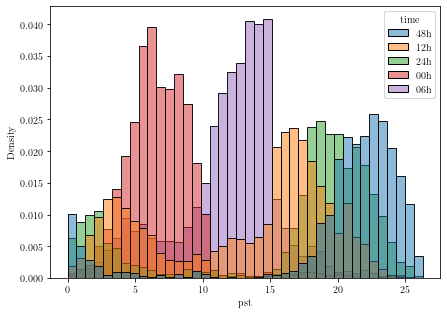

In [16]:
PST_df = pd.read_csv(path_data+'input_data/cellinfo_pseudotime_UMAPno2clcs_23_01_13.txt',
                              header = 0, sep = ' ', quotechar = '"', 
                              names = ["barcodes", "time", "pst"])

print("Min pseudotime: ", np.min(PST_df["pst"]), "- Max pseudotime: ", np.max(PST_df["pst"]))
print("Number of cells in PST df: ", PST_df.shape[0])

# sorting in ascending values of pseudo-time
PST_df = PST_df.sort_values(by=['pst'])
PST_df.tail(3)

# PLOT different times separated
plt.figure(figsize=(7,5))
sns.histplot(data=PST_df, x="pst", hue="time", stat="density", bins=40)

# histogram with all cell pseudotime
# sns.histplot(data=PST_df, x="pst", stat="density")


/var/folders/2z/hsgwjl3d49109llzgvkyf6jw0000gn/T/ipykernel_17461/2209648949.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  PST_df_new = PST_df_new.drop(PST_df_new[(PST_df["time"] == "24h") & (PST_df_new["pst"] < 8.0)].index)
/var/folders/2z/hsgwjl3d49109llzgvkyf6jw0000gn/T/ipykernel_17461/2209648949.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  PST_df_new = PST_df_new.drop(PST_df_new[(PST_df["time"] == "06h") & (PST_df_new["pst"] < 8.0)].index)
/var/folders/2z/hsgwjl3d49109llzgvkyf6jw0000gn/T/ipykernel_17461/2209648949.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  PST_df_new = PST_df_new.drop(PST_df_new[(PST_df["time"] == "12h") & (PST_df_new["pst"] < 8.0)].index)


              barcodes time        pst
9156  TTCAGGAAGCAGTACG  00h   0.000000
6252  GTAGATCAGTAGGTTA  00h   0.303601
3486  CGAAGGACACGGGCTT  00h   0.409823
6441  GTCGCGAGTCGTCTCT  00h   0.492022
3460  CCTTCAGGTCCAGCGT  00h   0.550231
...                ...  ...        ...
5202  GATTCGAAGATACAGT  24h  26.014790
5406  GCCAGGTAGAAGAACG  48h  26.075457
3834  CGTGCTTTCGACGTCG  48h  26.133877
1471  AGGGTGACAATACGAA  48h  26.139080
3016  CCACAAAAGCGTGAAC  48h  26.299378

[8273 rows x 3 columns]


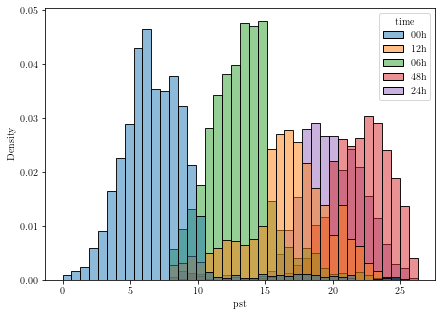

In [17]:
PST_df_new = PST_df.drop(PST_df[(PST_df["time"] == "48h") & (PST_df["pst"] < 8.0)].index)
PST_df_new = PST_df_new.drop(PST_df_new[(PST_df["time"] == "24h") & (PST_df_new["pst"] < 8.0)].index)
PST_df_new = PST_df_new.drop(PST_df_new[(PST_df["time"] == "06h") & (PST_df_new["pst"] < 8.0)].index)
PST_df_new = PST_df_new.drop(PST_df_new[(PST_df["time"] == "12h") & (PST_df_new["pst"] < 8.0)].index)
# PST_df_new = PST_df_new.drop(PST_df_new[(PST_df_new["pst"] < 3.00)].index)

print(PST_df_new)

plt.figure(figsize=(7,5))
sns.histplot(data=PST_df_new, x="pst", hue="time", stat="density", bins=40)

pst_df = PST_df_new.copy()

In [18]:
mb_wind=150
# riordino dataframe : PST
column_names = pst_df["barcodes"]
df_lN_pst = df_lN.reindex(columns = column_names)
# MB
df_lN_mb_pst = df_lN_pst.rolling(window=mb_wind, axis=1).mean().dropna(axis=1)
df_lN_mb_pst = pd.DataFrame(df_lN_mb_pst, index=df_lN_pst.index)
df_lN_mb_pst.head(3)



barcodes,CTACCTGAGAGCAACC,GGGATCCCAGTTGAAA,TGGGCGTAGAAGTGTT,TTGCGTCTCATCCCGT,CGGTCAGTCGATCCAA,CATCGTCCAACCGTGC,ATCACTTGTCGTTGCG,ATTCGTTGTTCGGTCG,TAGGTACAGGCTCTAT,GCGTTTCTCTCCAAGA,...,AACAAAGAGAGCGACT,TCATACTAGGTGTGAC,GCCATTCAGCCAGAGT,AACAGGGGTGCACGCT,GATCATGTCTGTAACG,GATTCGAAGATACAGT,GCCAGGTAGAAGAACG,CGTGCTTTCGACGTCG,AGGGTGACAATACGAA,CCACAAAAGCGTGAAC
1.1,,,,,,,,,,,,,,,,,,,,,
Klf4,0.742050,0.753709,0.753709,0.753709,0.767439,0.750540,0.734958,0.744650,0.744650,0.764925,...,0.141278,0.141278,0.133910,0.135940,0.128608,0.128608,0.128608,0.128608,0.128608,0.128608
Klf2,0.932831,0.938236,0.954685,0.947056,0.947056,0.947521,0.939299,0.948991,0.948991,0.946581,...,0.404834,0.404834,0.404834,0.414851,0.414851,0.424114,0.424114,0.416087,0.407699,0.400793
Esrrb,0.188526,0.188526,0.188526,0.188526,0.188526,0.188526,0.180303,0.180303,0.180303,0.166094,...,0.203270,0.195377,0.195377,0.187391,0.187391,0.187391,0.187391,0.187391,0.187391,0.180485


### Initial vector for SIMULATION

In [19]:
# Creating a column of integers from 0 to the length of the series
df_saving_index = pd.DataFrame(range(len(genes_order))).set_index(genes_order)

# concatenating the series and the index
result = pd.concat([df_saving_index, df_lN_mb_pst.iloc[:,:1000].mean(axis=1)], axis=1)
result
# Saving the resulting DataFrame as a tab-separated text file named 'result.txt'
result.to_csv(path_data+"OUT_SCODE_PN/initial_GE_PsiNorm_MB.txt", sep='\t', index=False, header=False)


In [20]:
data_LN = df_lN_mb_pst.copy()
data_LN.columns = np.arange(0,len(data_LN.columns))
data_LN.index = np.arange(0,len(data_LN.index))

data_LN.head(3)

,0,1,2,3,4,5,6,7,8,9,...,8114,8115,8116,8117,8118,8119,8120,8121,8122,8123
0,0.742050,0.753709,0.753709,0.753709,0.767439,0.750540,0.734958,0.744650,0.744650,0.764925,...,0.141278,0.141278,0.133910,0.135940,0.128608,0.128608,0.128608,0.128608,0.128608,0.128608
1,0.932831,0.938236,0.954685,0.947056,0.947056,0.947521,0.939299,0.948991,0.948991,0.946581,...,0.404834,0.404834,0.404834,0.414851,0.414851,0.424114,0.424114,0.416087,0.407699,0.400793
2,0.188526,0.188526,0.188526,0.188526,0.188526,0.188526,0.180303,0.180303,0.180303,0.166094,...,0.203270,0.195377,0.195377,0.187391,0.187391,0.187391,0.187391,0.187391,0.187391,0.180485


In [21]:
data_PST= pst_df.replace("00h", int(0)).replace("06h", int(6)).replace("12h", int(12)).replace("24h", int(24)).replace("48h", int(48))
data_PST = data_PST.iloc[:,1:] #remove Barcodes

#normalize pst between 0 and 1
data_PST["pst"]=data_PST["pst"]/(data_PST["pst"].max())

# rolling average
data_PST = data_PST.rolling(window=mb_wind, axis=0).mean().dropna(axis=0)
data_PST["time"] = data_PST["time"].astype('int')

# rename indices
data_PST.index = np.arange(0,len(data_PST.index))
print(data_PST.shape)
data_PST.head(5)




(8124, 2)


,time,pst
0,0,0.100720
1,0,0.101643
2,0,0.102494
3,0,0.103317
4,0,0.104126


## Check on RSS (100 trials)

In [22]:
# Train and Test
training_data = data_LN.sample(frac=0.8, random_state=2407, replace=False, axis=1)
testing_data  = data_LN.drop(training_data.columns, axis=1)

training_time = data_PST.loc[training_data.columns, :]
testing_time  = data_PST.drop(training_data.columns, axis=0)

# print(training_data.shape[1]+testing_data.shape[1])
print(training_data.shape, testing_data.shape)
print(training_time.shape, testing_time.shape)


(24, 6499) (24, 1625)
(6499, 2) (1625, 2)


# Matrices computation

In [23]:
# # path1 =  path+"1_NetworkInference/"

# # Train part with more executions
# genes = 24
# D = [2,3,4,6,8]
# cells_train = 6499
# cells_test = 1625
# iters = 100
# data_GE  = training_data
# data_PST = training_time
# Nexp=100

# for jj in range(len(D)):
#     print("D: ", D[jj])
#     for ii in range(Nexp):
#         print("Exp ", ii)
#         out="OUT_SCODE_PsiNorm/PST_MB/out_z"+str(D[jj])+"/exp_"+str(ii)
# #         if not os.path.isdir(out):
# #             os.makedirs(out)
        
#         # Train
#         ! Rscript ~/Downloads/SCODE-master/SCODE.R /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/Code/Work/1_NetworkInference/IN_SCODE/PST_MB/train_data.txt /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/Code/Work/1_NetworkInference/IN_SCODE/PST_MB/train_time.txt {out} {genes} {D[jj]} {cells_train} {iters}
#         # Test
#         out_file = "OUT_SCODE_PsiNorm/PST_MB/out_z"+str(D[jj])+"/exp_"+str(ii)+"/RSS_test.txt"
#         ! Rscript ~/Downloads/SCODE-master/RSS.R /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/Code/Work/1_NetworkInference/IN_SCODE/PST_MB/test_data.txt /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/Code/Work/1_NetworkInference/IN_SCODE/PST_MB/test_time.txt {out} {out_file} {genes} {D[jj]} {cells_test}
        


# From Here to not recompute ALL

In [24]:
# Compute D quantile
genes = 24
D = [2,4,6,8]
cells_train = 6499
cells_test = 1625
iters = 100
data_GE  = training_data
data_PST = training_time
Nexp=100

RSS_vect = np.zeros((len(D), Nexp))
RSS_quantile = np.zeros((3,len(D)))

# TP_vect = np.zeros((len(D),Nexp))
# TP_max = np.zeros(len(D))
# A_tot = np.zeros((genes, genes, len(D)))
# A_mean = np.zeros((genes, genes, len(D)))
A_sample = np.zeros((genes, genes, len(D), Nexp))
for jj in range(len(D)):
    print("D: ", D[jj])
    for ii in range(Nexp):
        out=       path_data+"OUT_SCODE_PN/PST_MB/out_z"+str(D[jj])+"/exp_"+str(ii)
        out_file = path_data+"OUT_SCODE_PN/PST_MB/out_z"+str(D[jj])+"/exp_"+str(ii)+"/RSS_test.txt"
        RSS_vect[jj,ii] = np.array(pd.read_csv(out_file, sep="\t", header=None))
#         print(D[jj], ii, RSS_vect[jj,ii])
        A_sample[:,:,jj,ii] = pd.read_csv(out+"/A.txt", sep="\t", header=None)
#         A_tot[:,:,jj] += locals()["A"+str(ii)]
#     A_mean = A_tot[:,:,jj]/Nexp
        
    RSS_quantile[:,jj] = np.array([np.quantile(RSS_vect[jj,:], 0.25), np.quantile(RSS_vect[jj,:], 0.5), np.quantile(RSS_vect[jj,:], 0.75)])
#     TP_max[jj] = TP_vect[jj,:].max()



D:  2
D:  4
D:  6
D:  8


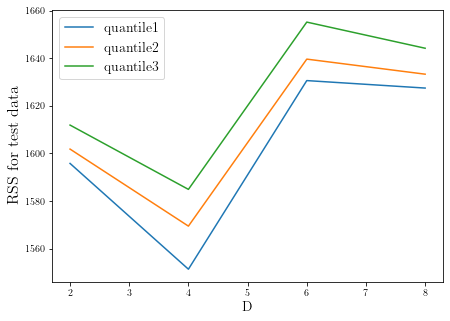

In [25]:
plt.figure(figsize=(7,5))
for ii in range(RSS_quantile.shape[0]):
    plt.plot(D, RSS_quantile[ii,:], label="quantile"+str(ii+1))
    plt.legend(fontsize=14)
    plt.ylabel("RSS for test data", fontsize=16)
    plt.xlabel("D", fontsize=14)    

In [26]:
# Per OGNI D: Devo riordinare in ordine crescente di RSS e poi prendere i 50 RSS più piccoli
A_sel = np.zeros((genes, genes, len(D), 50))
A_lin = np.zeros((genes*genes, len(D), 50))

for jj in range(len(D)):
    idx = np.argsort(RSS_vect[jj,:])[:50]  
    for ii in range(len(idx)):
        A_sel[:,:,jj,ii] = A_sample[:,:,jj,idx[ii]]
        A_lin[:,jj,ii] = A_sample[:,:,jj,idx[ii]].flatten()
        
    


In [27]:
A_lin.shape

(576, 4, 50)

In [28]:
A_quantile = np.zeros((3,len(D)))
for jj in range(len(D)):
    A_exp_corr = np.corrcoef(A_lin[:,jj,:].T)
#     print(np.quantile(A_exp_corr, 0.25))
    A_quantile[:,jj] = np.array([np.quantile(A_exp_corr, 0.25), np.quantile(A_exp_corr, 0.5), np.quantile(A_exp_corr, 0.75)])


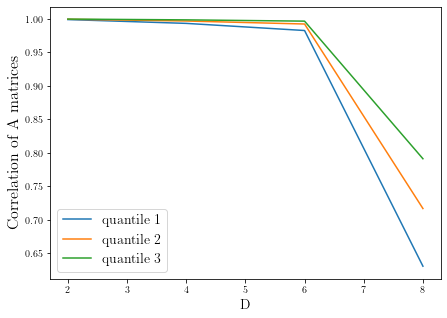

In [29]:
plt.figure(figsize=(7,5))
for ii in range(A_quantile.shape[0]):
    plt.plot(D, A_quantile[ii,:], label="quantile "+str(ii+1))
    plt.legend(fontsize=14)
    plt.ylabel("Correlation of A matrices", fontsize=16)
    plt.xlabel("D", fontsize=14) 

# Inferred Matrix with D=4

## Thr=0.01

thr= 0.01
D= 4


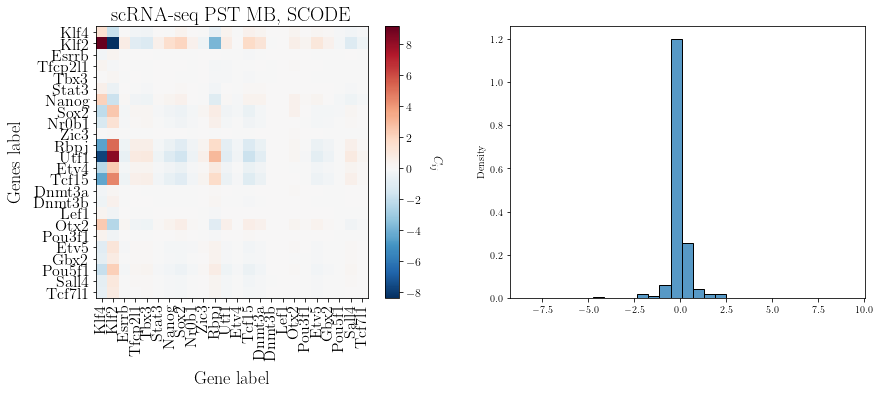

TP fraction  0.16666666666666666
Not Normalized TRUE interactions [ 0.   -0.   -0.    0.    0.   -0.    0.    0.    0.   -0.   -0.36 -0.13
  0.   -0.   -1.03 -0.    0.    0.  ]
Normalized TRUE interactions [ 0.   -0.   -0.    0.    0.   -0.    0.    0.    0.   -0.   -0.04 -0.01
  0.   -0.   -0.11 -0.    0.    0.  ]
Not Normalized interactions [ 0.06 -0.04 -0.01  0.34  0.04 -0.04  0.02  0.04  0.08 -0.01 -0.36 -0.13
  0.04 -0.02 -1.03 -0.07  0.04  0.05]
Normalized interactions [ 0.01 -0.   -0.    0.04  0.   -0.    0.    0.    0.01 -0.   -0.04 -0.01
  0.   -0.   -0.11 -0.01  0.    0.01]


In [30]:
sel_thr = 0.01
print("thr=", sel_thr)

DD = 1
print("D=", D[DD])
N_sel_A = 100
A_tot = np.sum(A_sel[:,:,DD,:N_sel_A], axis=2 )/N_sel_A
        

TP_fraction, TP_info, interaction_matrix = TP_plot(TPtrial_list, A_tot, genes_order, inferred_int_thr=sel_thr, 
                                                   Norm_Matx = False, data_type="scRNA-seq PST MB, SCODE",
                                                   figplot=True, nbin=30, 
                                                    verbose=False, Norm=True)
                                        
                                                   
                                                    
print("TP fraction ", TP_fraction)
# result = TP_info[2,:]*TP_info[3,:]
# non_zero_values = result[np.nonzero(result)]
# print(np.nanmin(np.abs(non_zero_values)))

print("Not Normalized TRUE interactions", np.round(TP_info[2,:]*TP_info[3,:],2))
print("Normalized TRUE interactions", np.round(TP_info[2,:]*TP_info[3,:]/np.max(np.abs(A_tot)), 2))

print("Not Normalized interactions", np.round(TP_info[2,:],2))
print("Normalized interactions", np.round(TP_info[2,:]/np.max(np.abs(A_tot)), 2))


### Fraction of discarded

In [31]:
high_meanMatx_thr = na.to_thr_matrix(A_tot, thr=sel_thr)
print(1-(len(np.where(high_meanMatx_thr==0)[0]))/(24**2))
print(len(np.where(A_tot==0)[0]))

0.43923611111111116
0


In [32]:
np.savetxt(path_data+"OUT_SCODE_PN/A_sel_PsiNorm_MB.txt",A_tot)

# Simulation

In [33]:
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)

In [34]:
out_sim = "/Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/out_simSCODE_PsiNorm_MB.txt"
N_genes = (24)

# call R script Reconstruct_dynamics.R
! Rscript /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/CODE/Reconstruct_dynamics.R /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/initial_GE_PsiNorm_MB.txt /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/A_sel_PsiNorm_MB.txt {out_sim} {24}

df_sim = pd.read_table(path_data+"OUT_SCODE_PN/out_simSCODE_PsiNorm_MB.txt", delimiter="\t", dtype={"Value": float}).set_index(genes_order)



Fatal error: non `e possibile aprire il file '/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/CODE/Reconstruct_dynamics.R': No such file or directory


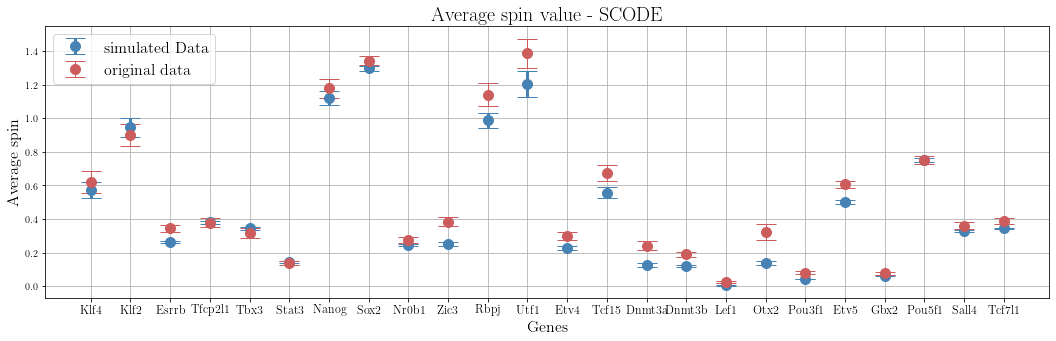

In [35]:
plt.figure(figsize=(18,5))
plt.errorbar(genes_order, df_sim.mean(axis=1), yerr=df_sim.std(axis=1)/np.sqrt(24),  
             alpha=1, 
             fmt="o", ms = 10,
             elinewidth=3,
             color="steelblue",
             capsize=10,
             label= "simulated Data")

plt.errorbar(genes_order, data_LN.mean(axis=1), yerr=data_LN.std(axis=1)/np.sqrt(24), 
             alpha=1, 
             fmt="o", ms = 10,
             elinewidth=1,
             color="indianred",
             capsize=10,
             label = "original data")
plt.legend(loc="upper left", fontsize=16)
plt.xticks(fontsize=12)
plt.ylabel("Average spin", fontsize=16)
plt.xlabel("Genes", fontsize=16)
plt.title("Average spin value - SCODE", fontsize=20)
plt.grid(True)

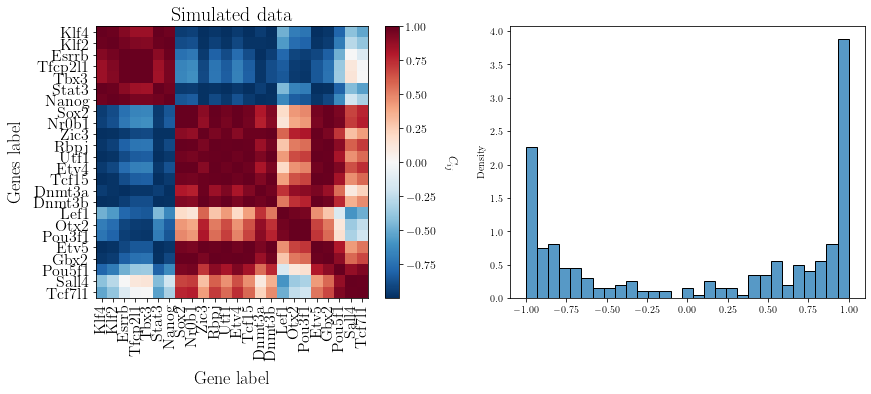

In [36]:
cm_sim_SCODE_PST_MB_pN_Cont = np.corrcoef(df_sim)

bins = np.linspace(-1, 1, 30)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
figfunc.plotmat(cm_sim_SCODE_PST_MB_pN_Cont, fig, ax[0], genes_order, "Simulated data")
sns.histplot(np.ndarray.flatten(cm_sim_SCODE_PST_MB_pN_Cont), bins=bins,  ax=ax[1], stat="density")
plt.show()

# # plt.imshow(np.corrcoef(spins_new_lN))
# print(np.where(spins_sim==float("nan")))



## Original CM

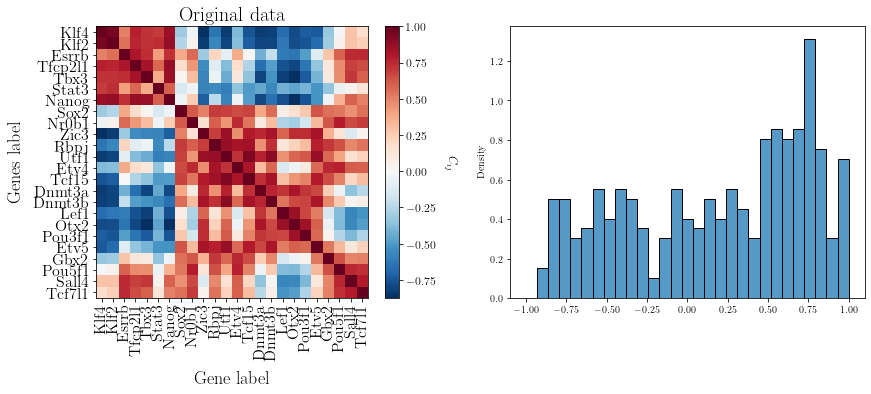

In [37]:
cm_pst_mb_psiNorm = np.corrcoef(data_LN)

bins = np.linspace(-1, 1, 30)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
figfunc.plotmat(cm_pst_mb_psiNorm, fig, ax[0], genes_order, "Original data")
sns.histplot(np.ndarray.flatten(cm_pst_mb_psiNorm), bins=bins,  ax=ax[1], stat="density")
plt.show()

### Distance

In [38]:
def sum_squared_abs_diff(array1, array2):
    diff = (array1.flatten()-array2.flatten())**2
    return np.sqrt(np.sum(diff))

In [39]:
N_rows = data_LN.shape[0]
N_cols = data_LN.shape[1]
Ntest=100
# Linearize
val_rnd = np.reshape(np.array(data_LN), (N_cols*N_rows))

# reshuflle for Ntest times
df_pN_mb_pst_shuffle = np.zeros((Ntest, N_rows, N_cols))

for ii in range(Ntest):
    np.random.seed(1234+ii)
    # Random reshuffle of the binnarized GE data
    np.random.shuffle(val_rnd)
    val_rnd_matx = val_rnd.reshape(N_rows,N_cols) ########################
    trial_long = pd.DataFrame(val_rnd_matx)

    # Save the shuffled DataFrame
    df_pN_mb_pst_shuffle[ii,:,:] = trial_long


corr_matxs_rnd = np.array([np.corrcoef(df_pN_mb_pst_shuffle[i,:,:]) for i in range(Ntest)])


In [40]:
noise_dist = [sum_squared_abs_diff(cm_pst_mb_psiNorm, corr_matxs_rnd[i,:,:]) for i in range(Ntest)]

noise_dist = np.mean(noise_dist)

result_SO = sum_squared_abs_diff(cm_pst_mb_psiNorm, cm_sim_SCODE_PST_MB_pN_Cont)/noise_dist
print(f"Scode - Orig {result_SO:.2f}")


Scode - Orig 0.82


In [41]:
# np.savetxt('cm_sim_SCODE_MB_PsiNorm.txt', cm_sim_SCODE_PST_MB_pN_Cont)

# KO

In [ ]:
def KO_comparison_ExpVsSim(lofFC_Exp, logFC_Sim, N_test=100):
    """compute the fraction of Experimental Data end Simulated data in Agreement"""
    comparison= np.array([np.sign(lofFC_Exp)*np.sign(logFC_Sim[ii,:]) for ii in range(N_test)])
#     print(np.sum([len(np.where(logFC_Sim[:,ii]==0)[0]) for ii in range(N_test)]))
    data_considered = np.array([len(np.where(comparison[ii,:]!=0)[0]) for ii in range(N_test)])
    
    in_agreement = np.array([len(np.where(comparison[ii,:]==1)[0])/data_considered[ii] for ii in range(N_test)])
    no_agreement = np.array([len(np.where(comparison[ii,:]==-1)[0])/data_considered[ii] for ii in range(N_test)])
    mean_in_agreement = np.mean(in_agreement)
    
    # Check
    check_sum = np.array([in_agreement[ii]+no_agreement[ii] for ii in range(N_test)])-1
    check = np.where(check_sum>0.001)[0]
    if check.size > 0:
        print("Error in comparison Exp and Sim")
    return(mean_in_agreement,    data_considered)


In [ ]:
def KO_plotLogFC_ExpAndSim(lofFC_Exp, logFC_Sim, KO_genes_order):
    plt.figure(figsize=(18,5))
    plt.plot(lofFC_Exp, 
             "o",ms = 10, label="Exp")
    plt.plot(logFC_Sim[:,0],  
             "o", ms = 10,
             color="darkred", label= "Sim")
    plt.xticks(np.arange(0,23),KO_genes_order)
    plt.axhline(0)
    plt.legend()

## Rpbj

In [ ]:
KO_gene = "Rbpj"
KO_gene_idk = np.where(genes_order ==KO_gene)[0][0]

# KO_lN_rec_matx = np.delete(lN_rec_matx, KO_gene_idk, axis=0)
KO_pN_rec_matx = np.delete(A_tot, KO_gene_idk, axis=0)
KO_pN_rec_matx = np.delete(KO_pN_rec_matx, KO_gene_idk, axis=1)

KO_genes_order = np.delete(genes_order, KO_gene_idk, axis=0)

KO_result = result.drop(KO_gene)
KO_result.to_csv(path_data+"OUT_SCODE_PN/KO_PN/RBPJ/initial_GE_PsiNorm_MB_KO.txt", sep='\t', index=False, header=False)

np.savetxt(path_data+ "OUT_SCODE_PN/KO_PN/RBPJ/A_KO_PsiNorm_MB.txt",KO_pN_rec_matx)


In [ ]:
N_sim=500
KO_df_sim = np.zeros((len(KO_genes_order), 101, N_sim))

for ii in range(N_sim):
    if ii%50==0:
        print("Exp ", ii)
    out_sim = "/Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/KO_PN/RBPJ/OUT/out_simSCODE_PsiNorm_MB_"+str(ii)+".txt"

    # call R script Reconstruct_dynamics.R
    ! Rscript /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/CODE/Reconstruct_dynamics.R /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/KO_PN/RBPJ/initial_GE_PsiNorm_MB_KO.txt /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/KO_PN/RBPJ/A_KO_PsiNorm_MB.txt {out_sim} {23}

    # load simulated data
    KO_df_sim[:,:,ii] = pd.read_table(path_data+"OUT_SCODE_PN/KO_PN/RBPJ/OUT/out_simSCODE_PsiNorm_MB_"+str(ii)+".txt", delimiter="\t", dtype={"Value": float}).set_index(KO_genes_order)
    KO_df_sim[KO_df_sim<0]=0
    

Exp  0
Exp  50
Exp  100
Exp  150
Exp  200
Exp  250
Exp  300
Exp  350
Exp  400
Exp  450


In [ ]:
KO_avg_GE = KO_df_sim.mean(axis=1)
KO_avg_GE_MeanTot = KO_avg_GE.mean(axis=1)
KO_std_GE_MeanTot = KO_avg_GE.std(axis=1)

wt_avg_GE = np.delete(np.array(data_LN.mean(axis=1)), KO_gene_idk)
wt_std_GE = np.delete(np.array(data_LN.std(axis=1)), KO_gene_idk)



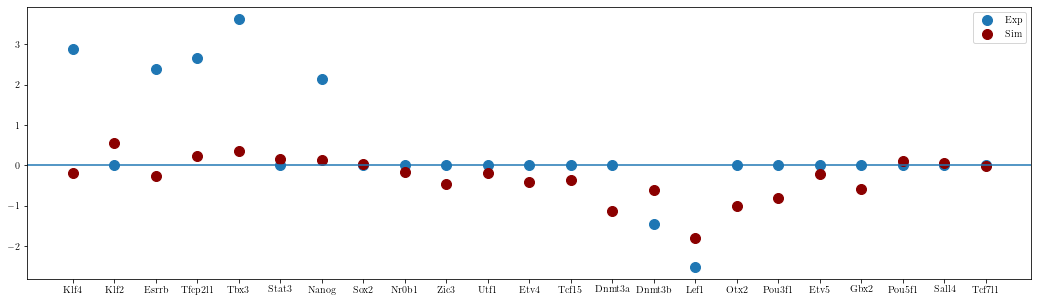

In [ ]:
logFC_Leeb_R = np.delete(np.array(df_KO_N24_Leeb_cl[KO_gene]), KO_gene_idk) # logFC Leeb


# Computed
logFC_Sim_R =  np.array([np.log2((KO_avg_GE[:,ii])/ (wt_avg_GE)) for ii in range(N_sim)])

KO_plotLogFC_ExpAndSim(logFC_Leeb_R, logFC_Sim_R.T, KO_genes_order)

In [ ]:
mean_in_agreement_R, data_considered_R  = KO_comparison_ExpVsSim(logFC_Leeb_R, logFC_Sim_R, N_sim)
print("Fraction of agreement: ", mean_in_agreement_R)
print("# of data Considered: ",data_considered_R.mean())

Fraction of agreement:  0.7142857142857142
# of data Considered:  7.0


## Etv5

In [ ]:
KO_gene = "Etv5"
KO_gene_idk = np.where(genes_order ==KO_gene)[0][0]

# KO_lN_rec_matx = np.delete(lN_rec_matx, KO_gene_idk, axis=0)
KO_pN_rec_matx = np.delete(A_tot, KO_gene_idk, axis=0)
KO_pN_rec_matx = np.delete(KO_pN_rec_matx, KO_gene_idk, axis=1)

KO_genes_order = np.delete(genes_order, KO_gene_idk, axis=0)

KO_result = result.drop(KO_gene)
KO_result.to_csv(path_data+"OUT_SCODE_PN/KO_PN/ETV5/initial_GE_PsiNorm_MB_KO.txt", sep='\t', index=False, header=False)

np.savetxt(path_data+ "OUT_SCODE_PN/KO_PN/ETV5/A_KO_PsiNorm_MB.txt",KO_pN_rec_matx)


In [ ]:
N_sim=500
KO_df_sim = np.zeros((len(KO_genes_order), 101, N_sim))

for ii in range(N_sim):
    if ii%50==0:
        print("Exp ", ii)
    out_sim = "/Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/KO_PN/ETV5/OUT/out_simSCODE_PsiNorm_MB_"+str(ii)+".txt"

    # call R script Reconstruct_dynamics.R
    ! Rscript /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/CODE/Reconstruct_dynamics.R /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/KO_PN/ETV5/initial_GE_PsiNorm_MB_KO.txt /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/KO_PN/ETV5/A_KO_PsiNorm_MB.txt {out_sim} {23}

    # load simulated data
    KO_df_sim[:,:,ii] = pd.read_table(path_data+"OUT_SCODE_PN/KO_PN/ETV5/OUT/out_simSCODE_PsiNorm_MB_"+str(ii)+".txt", delimiter="\t", dtype={"Value": float}).set_index(KO_genes_order)
    KO_df_sim[KO_df_sim<0]=0
    

Exp  0
Exp  50
Exp  100
Exp  150
Exp  200
Exp  250
Exp  300
Exp  350
Exp  400
Exp  450


In [ ]:
KO_avg_GE = KO_df_sim.mean(axis=1)
KO_avg_GE_MeanTot = KO_avg_GE.mean(axis=1)
KO_std_GE_MeanTot = KO_avg_GE.std(axis=1)

wt_avg_GE = np.delete(np.array(data_LN.mean(axis=1)), KO_gene_idk)
wt_std_GE = np.delete(np.array(data_LN.std(axis=1)), KO_gene_idk)



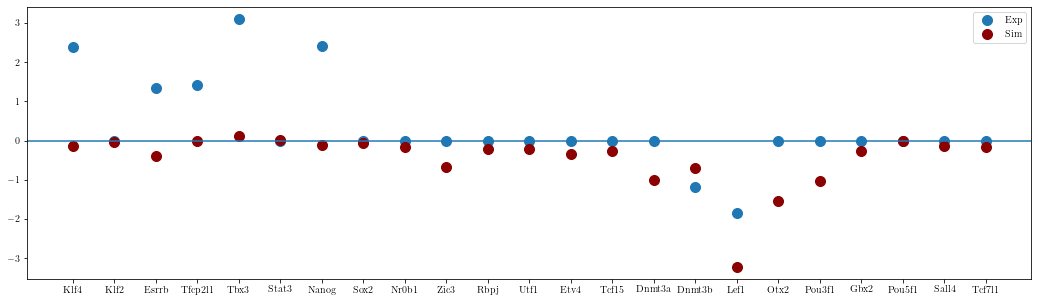

In [ ]:
logFC_Leeb_E = np.delete(np.array(df_KO_N24_Leeb_cl[KO_gene]), KO_gene_idk) # logFC Leeb


# Computed
logFC_Sim_E =  np.array([np.log2((KO_avg_GE[:,ii])/ (wt_avg_GE)) for ii in range(N_sim)])

KO_plotLogFC_ExpAndSim(logFC_Leeb_E, logFC_Sim_E.T, KO_genes_order)

In [ ]:
mean_in_agreement_E, data_considered_E  = KO_comparison_ExpVsSim(logFC_Leeb_E, logFC_Sim_E, N_sim)
print("Fraction of agreement: ", mean_in_agreement_E)
print("# of data Considered: ",data_considered_E.mean())

Fraction of agreement:  0.42857142857142855
# of data Considered:  7.0


## Tcf7l1

In [ ]:
KO_gene = "Tcf7l1"
KO_gene_idk = np.where(genes_order ==KO_gene)[0][0]

# KO_lN_rec_matx = np.delete(lN_rec_matx, KO_gene_idk, axis=0)
KO_pN_rec_matx = np.delete(A_tot, KO_gene_idk, axis=0)
KO_pN_rec_matx = np.delete(KO_pN_rec_matx, KO_gene_idk, axis=1)

KO_genes_order = np.delete(genes_order, KO_gene_idk, axis=0)

KO_result = result.drop(KO_gene)
KO_result.to_csv(path_data+"OUT_SCODE_PN/KO_PN/TCF7L1/initial_GE_PsiNorm_MB_KO.txt", sep='\t', index=False, header=False)

np.savetxt(path_data+ "OUT_SCODE_PN/KO_PN/TCF7L1/A_KO_PsiNorm_MB.txt",KO_pN_rec_matx)


In [ ]:
N_sim=500
KO_df_sim = np.zeros((len(KO_genes_order), 101, N_sim))

for ii in range(N_sim):
    if ii%50==0:
        print("Exp ", ii)
    out_sim = "/Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/KO_PN/TCF7L1/OUT/out_simSCODE_PsiNorm_MB_"+str(ii)+".txt"

    # call R script Reconstruct_dynamics.R
    ! Rscript /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/CODE/Reconstruct_dynamics.R /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/KO_PN/TCF7L1/initial_GE_PsiNorm_MB_KO.txt /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/KO_PN/TCF7L1/A_KO_PsiNorm_MB.txt {out_sim} {23}

    # load simulated data
    KO_df_sim[:,:,ii] = pd.read_table(path_data+"OUT_SCODE_PN/KO_PN/TCF7L1/OUT/out_simSCODE_PsiNorm_MB_"+str(ii)+".txt", delimiter="\t", dtype={"Value": float}).set_index(KO_genes_order)
    KO_df_sim[KO_df_sim<0]=0
    

Exp  0
Exp  50
Exp  100
Exp  150
Exp  200
Exp  250
Exp  300
Exp  350
Exp  400
Exp  450


In [ ]:
KO_avg_GE = KO_df_sim.mean(axis=1)
KO_avg_GE_MeanTot = KO_avg_GE.mean(axis=1)
KO_std_GE_MeanTot = KO_avg_GE.std(axis=1)

wt_avg_GE = np.delete(np.array(data_LN.mean(axis=1)), KO_gene_idk)
wt_std_GE = np.delete(np.array(data_LN.std(axis=1)), KO_gene_idk)



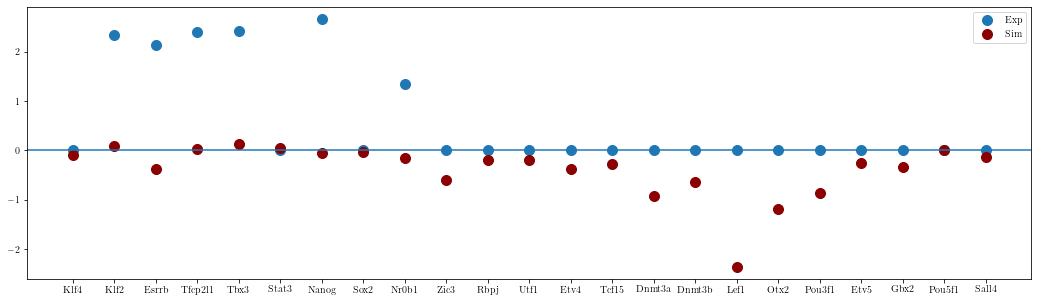

In [ ]:
logFC_Leeb_T = np.delete(np.array(df_KO_N24_Leeb_cl[KO_gene]), KO_gene_idk) # logFC Leeb


# Computed
logFC_Sim_T =  np.array([np.log2((KO_avg_GE[:,ii])/ (wt_avg_GE)) for ii in range(N_sim)])

KO_plotLogFC_ExpAndSim(logFC_Leeb_T, logFC_Sim_T.T, KO_genes_order)

In [ ]:
mean_in_agreement_T, data_considered_T  = KO_comparison_ExpVsSim(logFC_Leeb_T, logFC_Sim_T, N_sim)
print("Fraction of agreement: ", mean_in_agreement_T)
print("# of data Considered: ",data_considered_T.mean())

Fraction of agreement:  0.5
# of data Considered:  6.0


# Three KO

In [42]:
KO_gene = ["Rbpj", "Etv5", "Tcf7l1"]
KO_gene_idk = [np.where(genes_order == KO_gene[i])[0][0]  for i in range(len(KO_gene))]


KO_pN_rec_matx = np.delete(A_tot, KO_gene_idk, axis=0)
KO_pN_rec_matx = np.delete(KO_pN_rec_matx, KO_gene_idk, axis=1)

KO_genes_order = np.delete(genes_order, KO_gene_idk, axis=0)

KO_result = result.drop(KO_gene)
KO_result.to_csv(path_data+"OUT_SCODE_PN/KO_PN/MULT/initial_GE_PsiNorm_MB_KO.txt", sep='\t', index=False, header=False)

np.savetxt(path_data+ "OUT_SCODE_PN/KO_PN/MULT/A_KO_PsiNorm_MB.txt",KO_pN_rec_matx)


In [43]:
N_sim=100
KO_df_sim = np.zeros((len(KO_genes_order), 101, N_sim))
for ii in range(N_sim):
    if ii%5==0:
        print("Exp ", ii)
    out_sim = "/Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/KO_PN/MULT/OUT/out_simSCODE_PsiNorm_MB_"+str(ii)+".txt"

    # call R script Reconstruct_dynamics.R
    ! Rscript /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/GRN_Inference_CODE/Reconstruct_dynamics.R /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/KO_PN/MULT/initial_GE_PsiNorm_MB_KO.txt /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_PN/KO_PN/MULT/A_KO_PsiNorm_MB.txt {out_sim} {21}

    # load simulated data
    KO_df_sim[:,:,ii] = pd.read_table(path_data+"OUT_SCODE_PN/KO_PN/MULT/OUT/out_simSCODE_PsiNorm_MB_"+str(ii)+".txt", delimiter="\t", dtype={"Value": float}).set_index(KO_genes_order)
    KO_df_sim[KO_df_sim<0]=0
    



Exp  0
Exp  5
Exp  10
Exp  15
Exp  20
Exp  25
Exp  30
Exp  35
Exp  40
Exp  45
Exp  50
Exp  55
Exp  60
Exp  65
Exp  70
Exp  75
Exp  80
Exp  85
Exp  90
Exp  95


In [44]:
KO_avg_GE = KO_df_sim.mean(axis=1)
KO_avg_GE_MeanTot = KO_avg_GE.mean(axis=1)
KO_std_GE_MeanTot = KO_avg_GE.std(axis=1)
print("ko", KO_avg_GE.shape, KO_avg_GE_MeanTot.shape, KO_std_GE_MeanTot.shape)

wt_avg_GE = np.delete(np.array(data_LN.mean(axis=1)), KO_gene_idk)
wt_std_GE = np.delete(np.array(data_LN.std(axis=1)), KO_gene_idk)
print("wt", wt_avg_GE.shape)




ko (21, 100) (21,) (21,)
wt (21,)


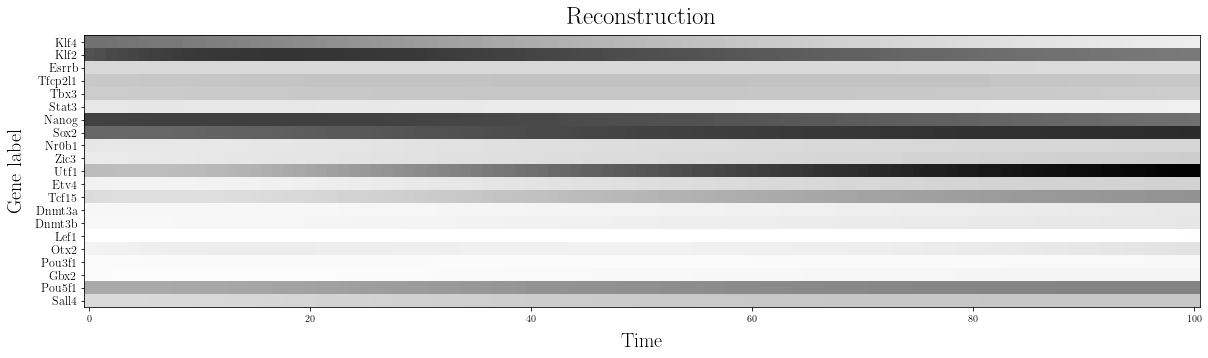

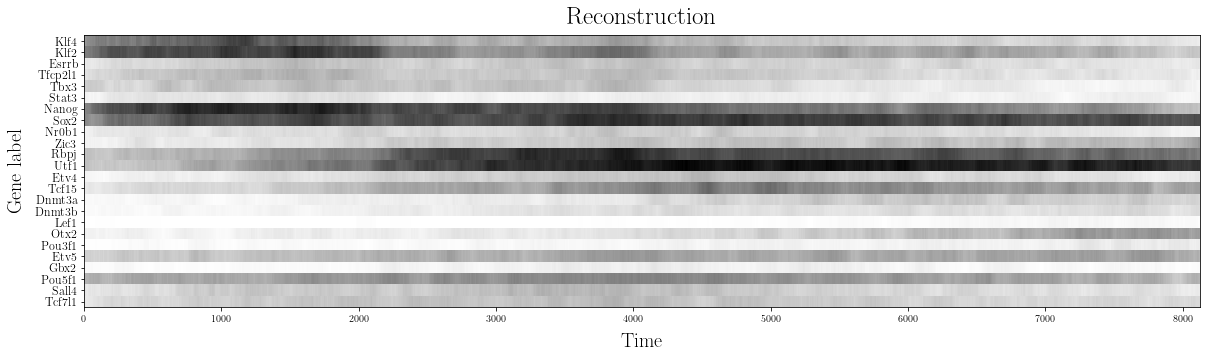

In [45]:
fun_plotting.raster_plot(KO_df_sim[:,:,0], 'Reconstruction', 1, KO_genes_order)
plt.show()

fun_plotting.raster_plot(np.array(df_lN_mb_pst), 'Reconstruction', 1, genes_order)
plt.show()

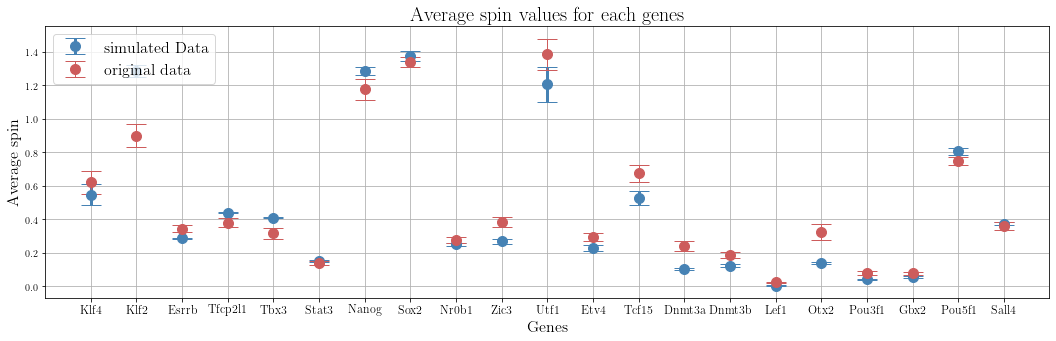

In [46]:
funcs_ko.KO_plots_SimMultiple_SCODE(KO_df_sim, KO_genes_order, wt_avg_GE, wt_std_GE)